# Imports and Setting up Plotting

In [1]:
from datetime import date, timedelta
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

rcParams = {'figure.max_open_warning': 0,
            'figure.figsize': (15, 8),
            'axes.grid': True}

plt.rcParams.update(rcParams)
plt.style.use('bmh')

pd.options.display.max_rows = 50

# Loading Data

In [2]:
# Reading CSV files and Loading the data
# filepath = r'c:\src\interview_project_data\*.csv'
filepath = r'D:\Documents\Projects\Python\OTPP\take-home-project\material\*.csv'
csv_files = glob.glob(filepath)

data = {}

for csv_file in csv_files:
    print('Loading ', csv_file)
    data_key = csv_file.rsplit('\\', 1)[-1].split('.')[0]    
    df = pd.read_csv(csv_file)
    df.set_index('dates', inplace=True)
    df.index = pd.to_datetime(df.index)
    data[data_key] = df
    
asset_prices = data['asset_prices']

# Firstly Grab the data by country
countries = ['US', 'CA']
data_labels = ['Unemployment', 'IndustrialProduction', 'GDP', 'HomeSales']

economic_data = {}

for country in countries:
    tmp_data = {}

    for label in data_labels:
        tmp_data[f'{label}'] = data[f'{country}_{label}']

    economic_data[f'{country}'] = tmp_data

Loading  D:\Documents\Projects\Python\OTPP\take-home-project\material\asset_prices.csv
Loading  D:\Documents\Projects\Python\OTPP\take-home-project\material\CA_GDP.csv
Loading  D:\Documents\Projects\Python\OTPP\take-home-project\material\CA_HomeSales.csv
Loading  D:\Documents\Projects\Python\OTPP\take-home-project\material\CA_IndustrialProduction.csv
Loading  D:\Documents\Projects\Python\OTPP\take-home-project\material\CA_Unemployment.csv
Loading  D:\Documents\Projects\Python\OTPP\take-home-project\material\US_GDP.csv
Loading  D:\Documents\Projects\Python\OTPP\take-home-project\material\US_HomeSales.csv
Loading  D:\Documents\Projects\Python\OTPP\take-home-project\material\US_IndustrialProduction.csv
Loading  D:\Documents\Projects\Python\OTPP\take-home-project\material\US_Unemployment.csv


## Examining Data

In [3]:
asset_prices

,ES1 Index,PT1 Index,CADUSD Curncy,DXY Curncy
dates,,,,
1980-01-01,NaN,NaN,0.8559,85.820
1980-01-02,NaN,NaN,0.8578,85.320
1980-01-03,NaN,NaN,0.8545,85.260
1980-01-04,NaN,NaN,0.8557,85.230
1980-01-07,NaN,NaN,0.8551,84.790
...,...,...,...,...
2023-01-20,3988.50,1237.2,0.7474,102.012
2023-01-23,4036.50,1244.9,0.7481,102.138
2023-01-24,4032.75,1244.1,0.7480,101.918


In [4]:
economic_data

{'US': {'Unemployment':             actual_value  expected_value  number_of_forecaster
  dates                                                         
  1997-02-07           5.4             5.3                   0.0
  1997-03-07           5.3             5.3                   0.0
  1997-04-04           5.2             5.2                   0.0
  1997-05-02           4.9             5.2                   0.0
  1997-06-06           4.8             5.0                   0.0
  ...                  ...             ...                   ...
  2022-05-06           3.6             3.5                  76.0
  2022-06-03           3.6             3.5                  69.0
  2022-07-08           3.6             3.6                  74.0
  2022-08-05           3.5             3.6                  71.0
  2022-09-02           3.7             3.5                  71.0
  
  [307 rows x 3 columns],
  'IndustrialProduction':             actual_value  expected_value  number_of_forecaster
  dates        

# Building An Indicator

<font color='red'>
I want to include GDP growth rate, GDP growth rate surprise, unemployment rate, and industrial production in my economic health indicator (EHI).

- GDP growth rate because it is a good indication of the growth of a country's economy.
- GDP growth rate surprise because it represents uncertainty and possible social or political changes whose economic impact are difficult to quantify. I'm going to be pessimistic and say that more uncertainty is bad for the economy.
- Unemployment rate because it often follows economic activity.
- Industrial production can be indicative of an economy's health, especially if it makes up a significant portion of its economic output.
- I want to leave out home sales because home sales lags as an indicator of income levels, and is also impacted by interest rates, social factors, and government policy in subsidizing home ownership. These change over time, and are in my opinion, not as important as an indication of economic health.
</font>

In [5]:
def normalize_raw_to_base(raw, base):
    template = pd.Series(None, index=base.index, dtype=base.dtype)
    combined = pd.concat([template, raw])
    combined = combined[~combined.index.duplicated(keep='last')].sort_index()
    filled = combined.ffill()
    base_subset = filled[base.index]
    return base_subset

In [6]:
ca_gdp = economic_data['CA']['GDP']['actual_value']
ca_gdp_expected = economic_data['CA']['GDP']['expected_value']
ca_gdp_surprise = abs(ca_gdp - ca_gdp_expected)
ca_unemployment_raw = economic_data['CA']['Unemployment']['actual_value']
ca_unemployment = normalize_raw_to_base(ca_unemployment_raw, ca_gdp)
ca_industrial_raw = economic_data['CA']['IndustrialProduction']['actual_value']
ca_industrial = normalize_raw_to_base(ca_industrial_raw, ca_gdp)

ca_indicator = (1 + (ca_gdp * (1 + ca_gdp_surprise.pow(0.5)))) * (ca_industrial) / ca_unemployment

ca_indicator.describe()

count    268.000000
mean       0.433086
std        3.024058
min       -0.634948
25%       -0.126301
50%        0.059381
75%        0.298152
max       40.743187
dtype: float64

In [7]:
us_gdp = economic_data['US']['GDP']['actual_value']
us_gdp_expected = economic_data['US']['GDP']['expected_value']
us_gdp_surprise = abs(us_gdp - us_gdp_expected)
us_unemployment_raw = economic_data['US']['Unemployment']['actual_value']
us_unemployment = normalize_raw_to_base(us_unemployment_raw, us_gdp)
us_industrial_raw = economic_data['US']['IndustrialProduction']['actual_value']
us_industrial = normalize_raw_to_base(us_industrial_raw, us_gdp)

us_indicator = (1 + (us_gdp * (1 + us_gdp_surprise.pow(0.5)))) * (us_industrial) / us_unemployment

us_indicator.describe()

count    99.000000
mean     -0.031197
std       3.854264
min     -35.764333
25%      -0.104872
50%       0.188060
75%       0.540717
max       9.932626
dtype: float64

# Building a Trading Signal Using the Indicator

In [8]:
def basic_signal(ts):
    # ts is a vector
    signal = pd.DataFrame(np.zeros((len(ts.index), 1)),index=ts.index, columns=['signal'])
    signal[ts > 0] = 1
    signal[ts < 0] = -1
    
    return signal

In [9]:
def trend_following_signal(ts):
    exp1 = ts.ewm(span=4, adjust=False).mean()
    exp2 = ts.ewm(span=9, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=2, adjust=False).mean()
    difference = macd - signal_line
    signal = pd.DataFrame(np.zeros((len(ts.index), 1)),index=ts.index, columns=['signal'])
    signal[difference > 0] = 1
    signal[difference < 0] = 1
    return signal    

In [10]:
def ewa_signal(ts):
    window = 8
    
    prev = ts.shift(window)
    spread = ts - prev
    rolling_std = ts.rolling(window).std()
    adjusted = spread / rolling_std
    smoothed = adjusted.ewm(span=window, adjust=False).mean()
    
    signal = pd.DataFrame(np.zeros((len(ts.index), 1)),index=ts.index, columns=['signal'])
    signal[smoothed > 0] = 1
    signal[smoothed < 0] = 1
    return signal 

In [11]:
ca_sgnl = ewa_signal(ca_indicator)
us_sgnl = ewa_signal(us_indicator)

## Show Performance of the Trading Signal

### Choose the assets you want to trade

In [12]:
# In this case, we are postulating that when the change in GDP is positive,
# both the country's stock market and the country's currency will rise.
ca_assets = ['PT1 Index', 'CADUSD Curncy']
us_assets = ['ES1 Index']

### Calculate PnL

In [13]:
def calculate_pnl(ret, pos):
    # function to calculate profit and loss
    # we trade at the end of the period, and take profit & loss on the market move next period on our position
    # that's why we are shifting positon vector by one
    return ret.multiply(pos.shift(), axis=0).dropna()

In [14]:
# build the return series for each of the series
ca_returns = asset_prices[ca_assets].pct_change()
us_returns = asset_prices[us_assets].pct_change()

# Resample the Signal into daily signal
ca_daily_pos = ca_sgnl.resample('D').ffill()
us_daily_pos = us_sgnl.resample('D').ffill()

In [15]:
us_pnl = calculate_pnl(us_returns, us_daily_pos['signal'])
ca_pnl = calculate_pnl(ca_returns, ca_daily_pos['signal'])

<AxesSubplot: title={'center': 'Cumulative Trading Profit - ewa'}, xlabel='dates'>

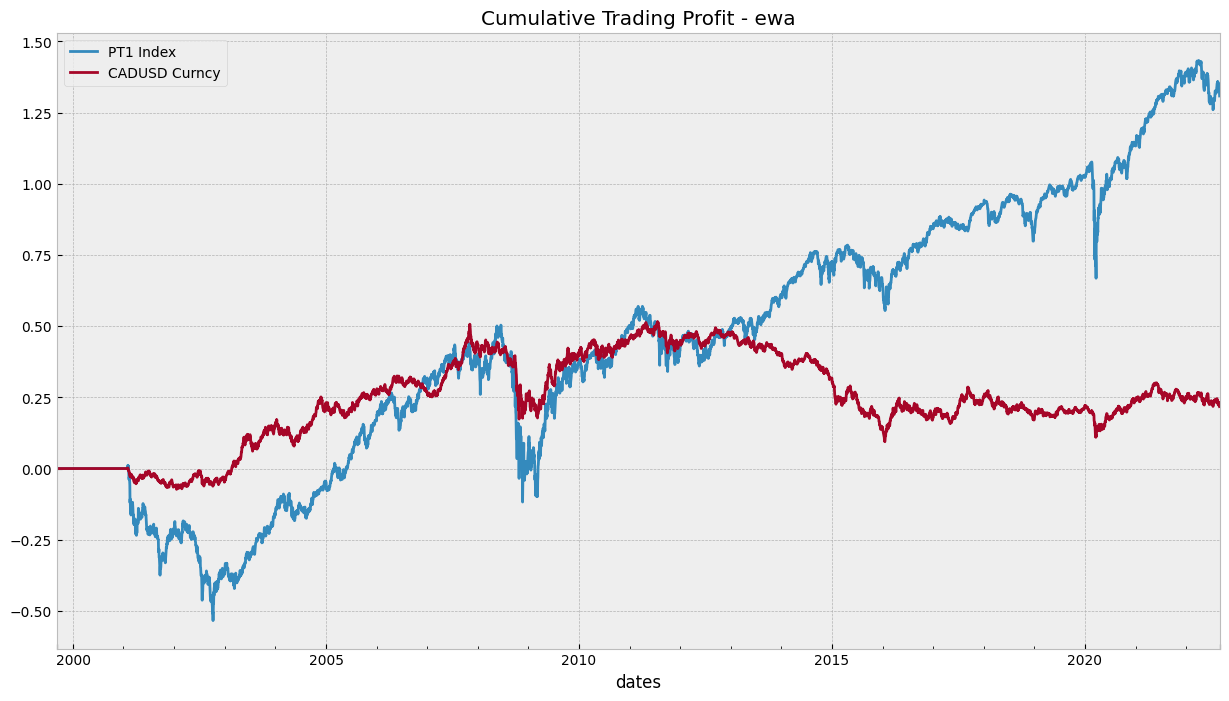

In [16]:
ca_pnl.cumsum().plot(title='Cumulative Trading Profit - ewa')

<AxesSubplot: title={'center': 'Cumulative Trading Profit - ewa'}, xlabel='dates'>

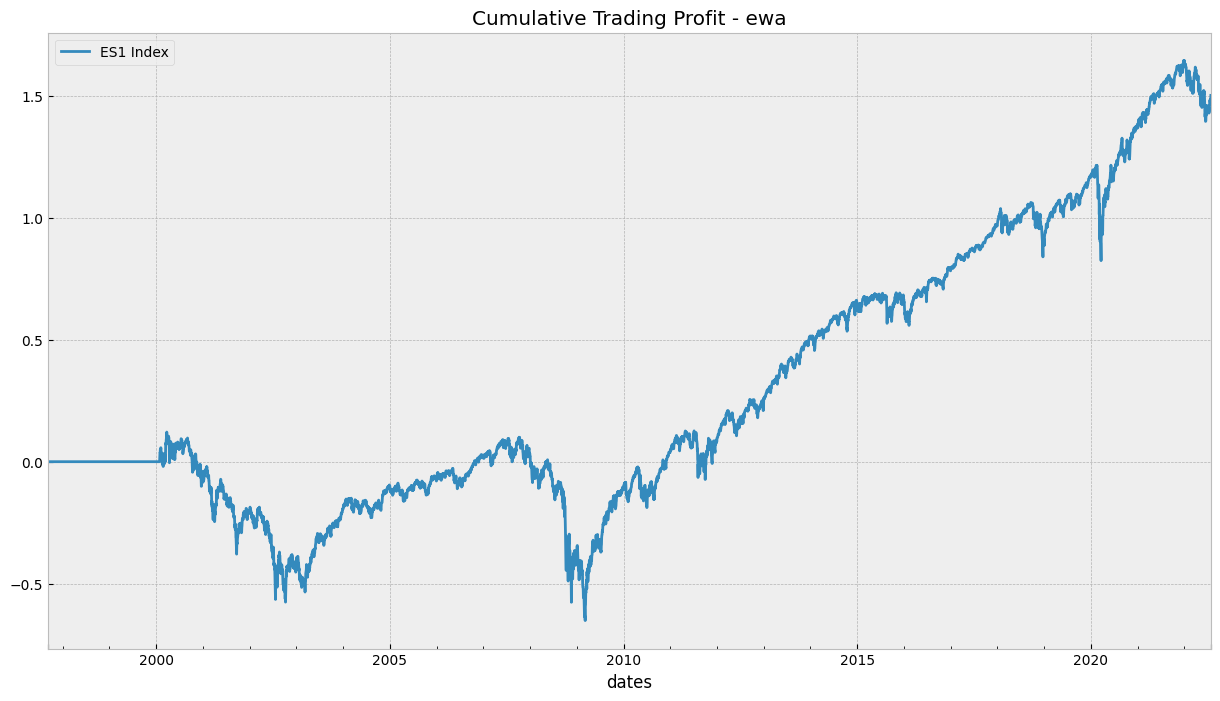

In [17]:
us_pnl.cumsum().plot(title='Cumulative Trading Profit - ewa')

## Some thoughts on the performance of the trading signal

Please examine the results of your trading signal and provide some commentary on the performance. 

If it performs well. Why? If it doesn't, why not? How can you make it better? 

What would be the next steps, if on the job, you are asked to further explore this investigation?

<font color='red'>
The results of trading on my trading signal are mixed.

The long-term results on PT1 Index and ES1 Index are positive, but suffered from the sustained price drops starting in 2001 and 2008.

Although not negative, the performance of my trading signal for CADUSD Curncy was lacklustre. I expected a stronger relationship between Canada's economic health indicator and its currency because the economy's strength depends on its exports.

I suspect that the indicator is not adequately accounting for the effect of unemployment rate. I should consider factoring home sales into the indicator as well, though perhaps only have it come into effect after numerous consecutive periods of decline, so as to not muddy the signal.

As next steps, I would investigate other major areas of undesirable results, and attempt to determine the reason for it – missing factor, underweight, or overweight of one or more factors. I would conduct multi factor analysis, determine the economic reasons for various historical broad asset movements that were incorrectly traded, and determine the best proxies for capturing those reasons into the economic indicator.
</font>